<a href="https://colab.research.google.com/github/fowardelcac/Titanic_2.0/blob/main/Modelos/Pca.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [1]:
! git clone https://github.com/fowardelcac/Titanic_2.0.git

Cloning into 'Titanic_2.0'...
remote: Enumerating objects: 162, done.
remote: Counting objects: 100% (25/25), done.
remote: Compressing objects: 100% (25/25), done.
remote: Total 162 (delta 6), reused 0 (delta 0), pack-reused 137
Receiving objects: 100% (162/162), 178.71 KiB | 5.42 MiB/s, done.
Resolving deltas: 100% (62/62), done.


In [2]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import random
import warnings

from sklearn.metrics import accuracy_score
from sklearn.model_selection import train_test_split
from sklearn.model_selection import GridSearchCV
from sklearn.preprocessing import OneHotEncoder
from sklearn.preprocessing import MinMaxScaler
from sklearn.decomposition import PCA

from sklearn.linear_model import LogisticRegression
from sklearn.neighbors import KNeighborsClassifier
from sklearn.tree import DecisionTreeClassifier
from sklearn.ensemble import RandomForestClassifier

warnings.filterwarnings('ignore')

In [7]:
def edit_age(df):
  serie = df['Age'].dropna()
  # Obtener la cantidad de valores nulos en la columna 'Age'
  size = df['Age'].isna().sum()
  # Generar una nueva Serie con valores aleatorios de la Serie 'serie'
  random_values = np.random.choice(serie, size=size)
  # Reemplazar los valores NaN en la columna 'Age' con los valores aleatorios
  df.loc[df['Age'].isna(), 'Age'] = random_values
  return df

def onehot(df):
  encoder = OneHotEncoder()
  data = pd.DataFrame(encoder.fit_transform(df['Pclass'].values.reshape(-1, 1)).toarray(), columns=['1', '2', '3'])
  return data

def edit(df):
  df = edit_age(df)

  mapeo = {'male': 0, 'female': 1}
  df.Sex = df.Sex.map(mapeo)
  
  df['familia'] = df.SibSp + df.Parch

  data = onehot(df)
  df.reset_index('PassengerId', inplace=True)
  df = pd.concat([df, data], axis=1).set_index('PassengerId')

  scaler = MinMaxScaler().fit_transform(df['Fare'].values.reshape(-1, 1))
  scaled_series = pd.Series(scaler.flatten(), index=df.index)
  df.Fare = scaled_series

  scaler = MinMaxScaler().fit_transform(df['Age'].values.reshape(-1, 1))
  scaled_series = pd.Series(scaler.flatten(), index=df.index)
  df.Age = scaled_series


  df.drop(['SibSp', 'Parch', 'Cabin', 'Ticket', 'Name', 'Embarked'], axis = 1, inplace = True)
  return df   

In [4]:
def split(df):
  n = len(df.columns)
  X = df.drop('Survived', axis=1).values.reshape((-1, n - 1))
  y = df.Survived
  X_train, X_test, y_train, y_test = train_test_split(X, y, train_size = 0.3, random_state = 42)
  return X_train, X_test, y_train, y_test

def modelar(modelo, X_train, y_train):
   return modelo.fit(X_train, y_train) 

def predecir(modelo, X_test, y_test, accuracy_score):
  y_pred = modelo.predict(X_test)
  score = round(accuracy_score(y_test, y_pred), 3)
  return score

def predecir_rdo(modelo, X_test):
  return modelo.predict(X_test)

In [5]:
def random_samples():
  columnas = ['Sex', 'Age', 'Fare', 'familia', 'Pclass']
  n_col =  random.randint(1, len(columnas))
  random_c = random.sample(columnas, n_col)
  return random_c

def create_df_azar(df):
  columnas = random_samples()
  data = df.filter(columnas, axis = 1)
  data['Survived'] = df.Survived
  return data

def modelar_(df):
  modelos_lista = [RandomForestClassifier(), DecisionTreeClassifier(), KNeighborsClassifier(), LogisticRegression()]
  data = create_df_azar(df)
  cols_d = data.columns[:-1]
  
  X_train, X_test, y_train, y_test = split(data)
  dic_m = {}
  for i in modelos_lista:  
    modelo = modelar(i, X_train, y_train)
    acc = predecir(modelo, X_test, y_test, accuracy_score)
    dic_m[i] = [cols_d, acc]
  return dic_m

In [6]:
def grid(modelo, params, X_train, y_train):
  grid_rf = GridSearchCV(modelo, params, cv = 5).fit(X_train, y_train)
  mejores_parametros = grid_rf.best_params_
  mejor_score = grid_rf.best_score_

  print("Mejores parámetros:", mejores_parametros)
  print("Mejor score:", mejor_score)

def rdo(test, y_pred):
  return pd.DataFrame(
    {
    'Survived': y_pred
    }, index= test.index )
   

In [8]:
df = pd.read_csv('/content/Titanic_2.0/Datasets_originales/train.csv').set_index('PassengerId')
df = edit(df)
df.head()

,Survived,Pclass,Sex,Age,Fare,familia,1,2,3
PassengerId,,,,,,,,,
1,0,3,0,0.271174,0.014151,1,0.0,0.0,1.0
2,1,1,1,0.472229,0.139136,1,1.0,0.0,0.0
3,1,3,1,0.321438,0.015469,0,0.0,0.0,1.0
4,1,1,1,0.434531,0.103644,1,1.0,0.0,0.0
5,0,3,0,0.434531,0.015713,0,0.0,0.0,1.0


In [24]:
def pca_(df):
  pca = PCA(n_components = 2)
  pca.fit(df)
  data_transf = pca.transform(df)
  data_transf.shape

  return  data_transf[:, 0],  data_transf[:, 1]

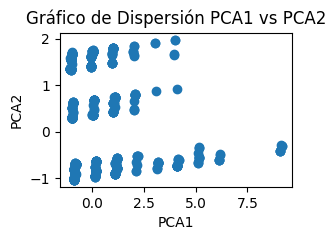

<Axes: xlabel='columnas', ylabel='var'>

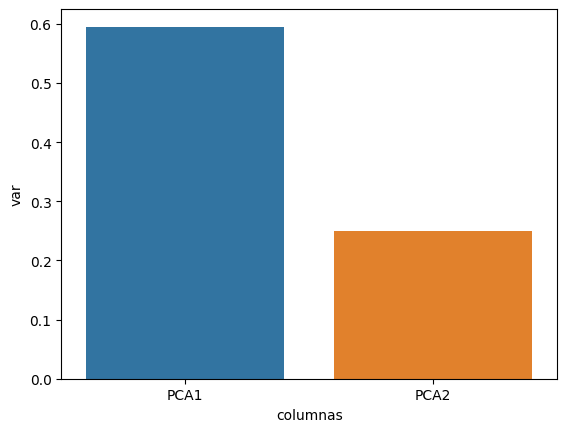

In [25]:
data_transf0,  data_transf1 = pca_(df)
df_final = pd.DataFrame({'PCA1': data_transf0,
                         'PCA2': data_transf1,
                         'Survived': df.Survived 
                         }, index = df.index)

plt.figure(figsize=(3,2))
plt.scatter(data=df_final, x='PCA1', y='PCA2')
plt.xlabel('PCA1')
plt.ylabel('PCA2')
plt.title('Gráfico de Dispersión PCA1 vs PCA2')
plt.show()

var_pca = pd.DataFrame({
    'columnas': ['PCA1', 'PCA2'],
    'var': pca.explained_variance_ratio_
})
sns.barplot(data = var_pca, x = 'columnas', y = 'var')

In [26]:
X_train, X_test, y_train, y_test = split(df_final)
modelos_lista = [RandomForestClassifier(), DecisionTreeClassifier(), KNeighborsClassifier(), LogisticRegression()]
for i in modelos_lista:
  modelo = modelar(i, X_train, y_train)
  acc = predecir(modelo, X_test, y_test, accuracy_score)
  print(f"Modelo: {i}, score:", acc)

Modelo: RandomForestClassifier(), score: 0.97
Modelo: DecisionTreeClassifier(), score: 0.96
Modelo: KNeighborsClassifier(), score: 0.902
Modelo: LogisticRegression(), score: 0.688


In [27]:
test = pd.read_csv('/content/Titanic_2.0/Datasets_originales/test.csv').set_index('PassengerId')
test = edit(test)
test.Fare.fillna(test.Fare.mean(), inplace=True)

In [28]:
data_transf0,  data_transf1 = pca_(test)
df_final = pd.DataFrame({'PCA1': data_transf0,
                         'PCA2': data_transf1
                         }, index = test.index)


In [40]:
modelo_rf = modelar(KNeighborsClassifier(), X_train, y_train)

In [41]:
X_test = df_final.filter(['PCA1',	'PCA2'], axis=1)

In [42]:
test_rdo_knn = rdo(test, predecir_rdo(modelo_rf, X_test))
test_rdo_knn.to_csv('knn1.csv')